# HW3: GLM

@roman avj
2 march 2024

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Problem 1: MC integration

Estimate $\int_{0}^{\pi/3}\sin(t)dt$ using the Monte Carlo method. 

In [2]:
from scipy.integrate import simpson

## S1: Numerical Integration

In [3]:
# function to estimate
def f1(x):
    return np.sin(x)

# get integral of f1 from 0 to pi/3
x = np.linspace(0, np.pi/3, 1000)
y = f1(x)
integral = simpson(y=y, x=x)
print(f"Integral of sin(x) from 0 to pi/3: {integral}")

Integral of sin(x) from 0 to pi/3: 0.49999999999997796


## S2: Analytical solution

In [4]:
ival_true = np.round(1 - np.cos(np.pi/3), 2)
print(f"True value: {ival_true}")

True value: 0.5


## S3: Monte Carlo Integration

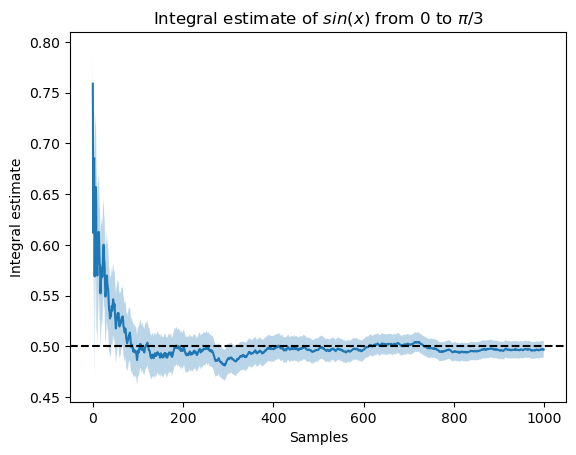

Integral of sin(x) from 0 to pi/3: 0.4969774217334744


In [5]:
# init random state
RNG = np.random.default_rng(42)

# step 1: generate random numbers in integration interval
x = RNG.uniform(0, np.pi/3, 1000)

# step 2: evaluate function at random points
y = f1(x)

# step 3: estimate integral using mean value
n_cum = np.arange(1, y.shape[0] + 1)
ival = (np.cumsum(y) / n_cum) * (np.pi/3 - 0)
ival_std = np.sqrt(np.cumsum((y - ival)**2)) / n_cum

# step 4: plot 
fig, ax = plt.subplots()
ax.plot(ival)
ax.fill_between(range(len(ival)), ival - ival_std, ival + ival_std, alpha=0.3)
ax.axhline(ival_true, color='k', linestyle='--')
ax.set_xlabel("Samples")
ax.set_ylabel("Integral estimate")
ax.set_title("Integral estimate of $sin(x)$ from 0 to $\pi/3$")
plt.show()

print(f"Integral of sin(x) from 0 to pi/3: {ival[-1]}")

# Problem 2: $F \sim \mathcal{Be}(3, 3)$

In [6]:
from scipy.stats import beta

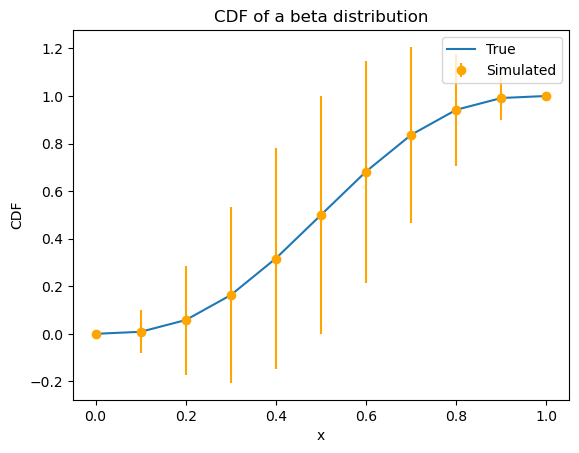

In [7]:
# fix random seed
RNG = np.random.default_rng(42)

# estimate cdf of a beta distribution
def cdf_beta(x, a, b, n=1000):
    # simulate random numbers
    z = RNG.beta(a, b, n)

    # get cdf
    return np.mean(z < x), np.std(z < x)

# get cdf of beta distribution
x = np.linspace(0, 1, 11)
cdf_sim = np.array([cdf_beta(xi, 3, 3, n=int(2e+4)) for xi in x])
cdf_beta = np.array([beta.cdf(xi, 3, 3) for xi in x])

# plot cdf
fig, ax = plt.subplots()
ax.errorbar(x, cdf_sim[:, 0], yerr=cdf_sim[:, 1], label="Simulated", color="orange", fmt="o")
ax.plot(x, cdf_beta, label="True")
ax.set_xlabel("x")
ax.set_ylabel("CDF")
ax.set_title("CDF of a beta distribution")
ax.legend()
plt.show()


In [8]:
# show table of cdf, format 4 decimal places
pd.DataFrame({"X": x, "Simulated_CDF": cdf_sim[:, 0], "True_CDF": cdf_beta}).style.format("{:.4f}")

,X,Simulated_CDF,True_CDF
0,0.0000,0.0000,0.0000
1,0.1000,0.0082,0.0086
2,0.2000,0.0563,0.0579
3,0.3000,0.1626,0.1631
4,0.4000,0.3149,0.3174
5,0.5000,0.4990,0.5000
6,0.6000,0.6814,0.6826
7,0.7000,0.8357,0.8369
8,0.8000,0.9410,0.9421
9,0.9000,0.9912,0.9914


# Problem 3: Monte Carlo integration
$$
\int_{0}^{1} \frac{e^{-x}}{1 + x^2}dx
$$


In [9]:
# problem 
def f2(x):
    return np.exp(-x) / (1 + x**2)
    

In [10]:
# numerical integration
x = np.linspace(0, 1, int(1e+3))
y = f2(x)
ival_true = simpson(y=y, x=x)
print(f"Integral of exp(-x) / (1 + x^2) from 0 to 1: {ival_true}")

Integral of exp(-x) / (1 + x^2) from 0 to 1: 0.5247971432601816


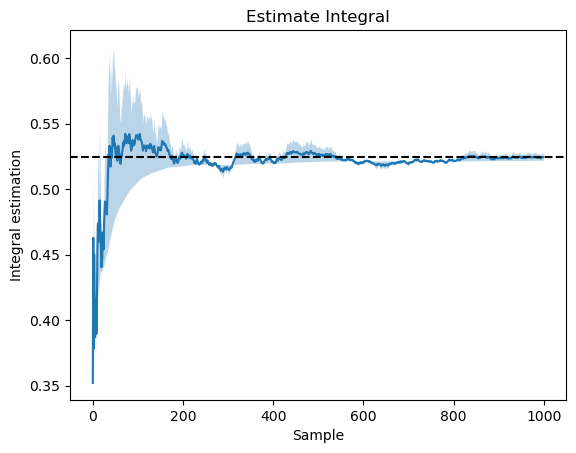

Integral value: 0.5244456986656403


In [11]:
# montecarlo integration
x = RNG.uniform(0, 1, int(1e+3))
y = f2(x)

# estimate
n_cum = np.arange(1, y.shape[0] + 1)
ival = np.cumsum(y)/n_cum * (1 - 0)
ival_std = np.sqrt(np.cumsum(y - ival)**2) / n_cum

# plot
fig, ax = plt.subplots()
ax.plot(ival)
ax.fill_between(n_cum, ival - ival_std, ival + ival_std, alpha=0.3)
ax.axhline(ival_true, color='k', linestyle='--')
ax.set_xlabel("Sample")
ax.set_ylabel("Integral estimation")
ax.set_title("Estimate Integral")
plt.show()

print(f"Integral value: {ival[-1]}")

In [12]:
# get n required for +/-0.001 error
imin = np.argmax(ival_std[1:] < 0.001)
print(f"Necessary number of sims: {imin + 1}; for error +/- {0.001}")

Necessary number of sims: 7; for error +/- 0.001


^^^ duda

# Problem 5: importance functions

$$
g(x) = \frac{x^{2}}{\sqrt{2\pi}}e^{-x^2/2}, x > 1
$$

Text(0.5, 1.0, 'g(x)')

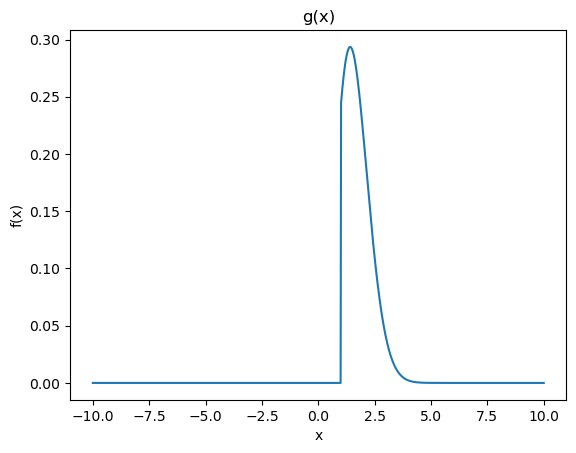

In [13]:
# function
def f3(x):
    return np.where(
        x > 1,
        x**2/np.sqrt(2 * np.pi) * np.exp(-x**2/2), 0
    )

# graph
x = np.linspace(-10, 10, int(1e+3))
y = f3(x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("g(x)")

## S1: proposal distribution $f_1(x)$

$$
f_1(x) \propto \frac{1}{\sqrt{2 \pi}}e^{-x/2}, x > 1
$$

In [14]:
from scipy.stats import norm

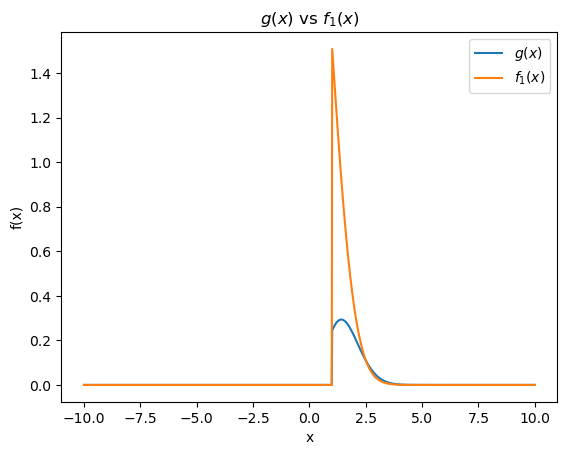

In [15]:
# get proposal 1
def f1_proposal(x):
    # get raw proposal
    fx = lambda z: np.where(
        z > 1,
        1/np.sqrt(2 * np.pi) * np.exp(-z**2/2), 0
    )

    # get normalizing constant
    const = norm.cdf(np.inf) - norm.cdf(1)

    # return proposal
    return fx(x) / const

# plot proposal 1 vs f3
y_proposal = f1_proposal(x)
fig, ax = plt.subplots()
ax.plot(x, y, label="$g(x)$")
ax.plot(x, y_proposal, label="$f_1(x)$")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("$g(x)$ vs $f_1(x)$")
ax.legend()


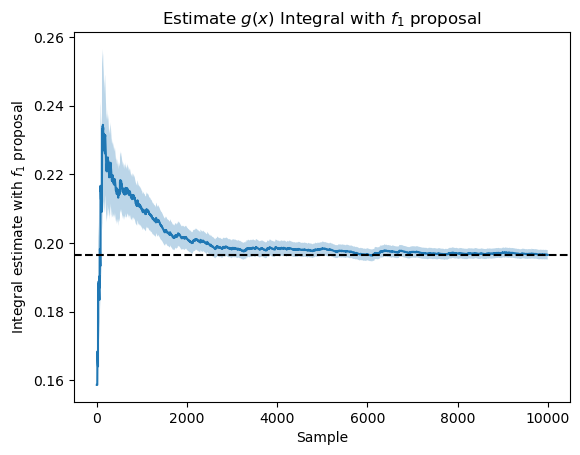

In [16]:
# step 1: simulate from proposal
x = np.maximum(RNG.normal(size=int(1e+4)), 1 + np.finfo(float).eps)  # x ~ f1

# step 2: unbiased estimate
n_cum = np.arange(1, x.shape[0] + 1)
y = f3(x) / f1_proposal(x)
ival = np.cumsum(y) / n_cum
ival_std = np.sqrt(np.cumsum((y - ival)**2)) / n_cum

# plot
fig, ax = plt.subplots()
ax.plot(ival)
ax.fill_between(n_cum, ival - ival_std, ival + ival_std, alpha=0.3)
ax.axhline(ival[-1], color='k', linestyle='--')
ax.set_xlabel("Sample")
ax.set_ylabel("Integral estimate with $f_1$ proposal")
ax.set_title("Estimate $g(x)$ Integral with $f_1$ proposal")
plt.show()


## S2: proposal distribution $f_2(x)$
$$
f2(x) = e^{-x} + 1
$$

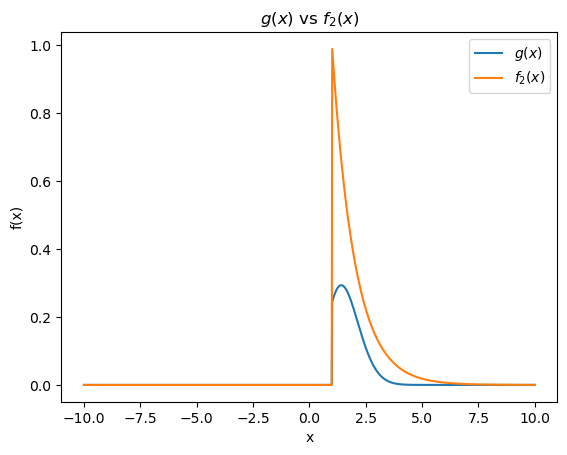

In [17]:
# get proposal 2
def f2_proposal(x):
    return np.where(x > 1, np.exp(-x) / np.exp(-1), 0)

# plot proposal 2 vs f3
x = np.linspace(-10, 10, int(1e+3))
y = f3(x)
y_proposal = f2_proposal(x)
fig, ax = plt.subplots()
ax.plot(x, y, label="$g(x)$")
ax.plot(x, y_proposal, label="$f_2(x)$")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("$g(x)$ vs $f_2(x)$")
ax.legend()


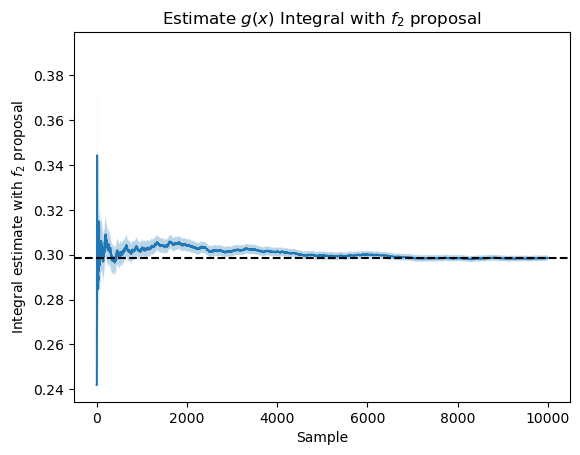

In [18]:
# step 1: simulate from proposal
x = np.maximum(RNG.exponential(size=int(1e+4)), 1 + np.finfo(float).eps)  # x ~ f1

# step 2: unbiased estimate
n_cum = np.arange(1, x.shape[0] + 1)
y = f3(x) / f2_proposal(x)
ival = np.cumsum(y) / n_cum
ival_std = np.sqrt(np.cumsum((y - ival)**2)) / n_cum

# plot
fig, ax = plt.subplots()
ax.plot(ival)
ax.fill_between(n_cum, ival - ival_std, ival + ival_std, alpha=0.3)
ax.axhline(ival[-1], color='k', linestyle='--')
ax.set_xlabel("Sample")
ax.set_ylabel("Integral estimate with $f_2$ proposal")
ax.set_title("Estimate $g(x)$ Integral with $f_2$ proposal")
plt.show()


## S3: get real integral

In [19]:
# estimate with simpson
x = np.linspace(1, int(1e+5), int(1e+5))
y = f3(x)
ival_true = simpson(y=y, x=x)
print(f"Integral of g(x) from -inf to inf: {ival_true}")

Integral of g(x) from -inf to inf: 0.31742302729140304


# Problem 6: Cauchy Metroplis-Hastings

In [36]:
# get cauchy from scipy
from scipy.stats import cauchy

RNG = np.random.default_rng(42)

In [39]:
# metropolis hastings for cauchy (using random walk acceptance)
def mh_generic(f, n=10_000, burn_in=1_000, sigma=1, x0=0):
    # mh ratio
    def mh_ratio(x, y):
        alpha_raw = (
            (f(y) * norm.pdf(x, loc=y, scale=1)) /
            (f(x) * norm.pdf(y, loc=x, scale=1))
        )
        return np.minimum(alpha_raw, 1)

    # number of total samples
    n = int(n)
    burn_in = int(burn_in)
    n_samples = int(n + burn_in)

    # step 1: init values
    z = np.empty(shape=n_samples)
    acceptance = np.empty(shape=n_samples-1)
    z[0] = x0

    # step 2: sample
    u = RNG.uniform(size=n_samples-1)
    for i in tqdm(range(1, n_samples)):
        # new proposal
        y = RNG.normal(loc=z[i-1], scale=sigma, size=1)[0]
        # ratio
        alpha = mh_ratio(z[i-1], y)
        # acceptance
        acceptance[i-1] = np.sign(alpha - u[i-1])
        z[i] = y if acceptance[i-1] >= 0 else z[i-1]

    # step 3: burn-in
    z = z[burn_in:]
    acceptance = acceptance[burn_in:]

    return {
        'sample': z,
        'rejection': np.mean(acceptance < 0)
    }

def plot_sample(dict_mh):
    # plot chain and histogram in same figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # plot chain
    ax[0].plot(dict_mh['sample'], alpha=0.5, linewidth=0.5)
    ax[0].set_title('Chain')
    # add rejection rate
    ax[0].text(
        0, 0,
        f'Rejection: {dict_mh["rejection"]:.2%}',
        transform=ax[0].transAxes
        )
    # xtitle
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('x')
    # plot histogram normalized
    ax[1].hist(dict_mh['sample'], bins=30, alpha=0.5, density=True)
    ax[1].set_title('MH Sampling')
    ax[1].set_xlabel('x')

    # show plot
    plt.show()



100%|██████████| 10999/10999 [00:04<00:00, 2314.99it/s]


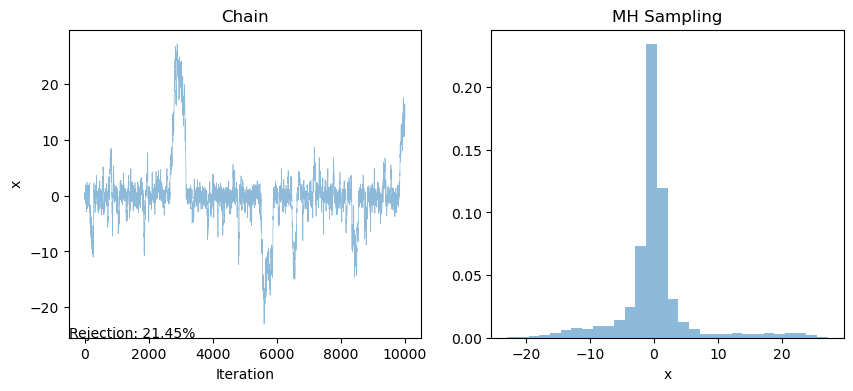

In [40]:
# plot cauchy
x_cauchy = mh_generic(
    f=cauchy.pdf, burn_in=1e+3, sigma=1
)

plot_sample(x_cauchy)

<Axes: xlabel='Deciles'>

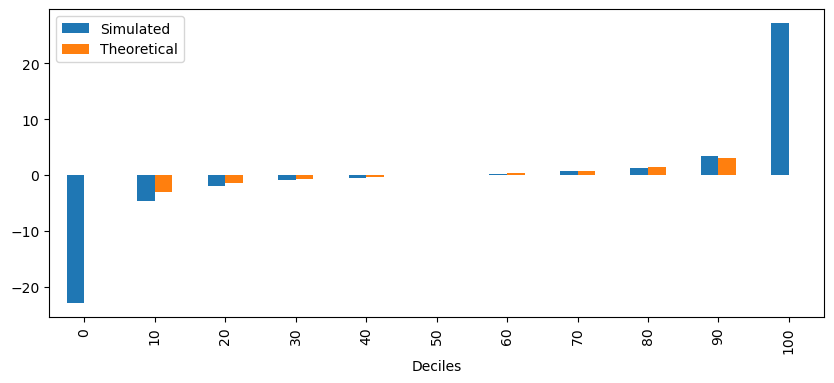

In [81]:
# compare deciles with cauchy
sim_deciles = np.percentile(x_cauchy['sample'], np.arange(0, 101, 10))
theoretical_deciles = cauchy.ppf(np.arange(0, 101, 10)/100)
theoretical_deciles
# look
pd.DataFrame({
    "Deciles": np.arange(0, 101, 10),
    "Simulated": sim_deciles,
    "Theoretical": theoretical_deciles
    }).plot(
            x="Deciles", y=["Simulated", "Theoretical"],
            kind="bar", figsize=(10, 4)
        )

# Problem 7: MH for laplace distribution

In [41]:
from scipy.stats import laplace

100%|██████████| 10999/10999 [00:04<00:00, 2406.90it/s]


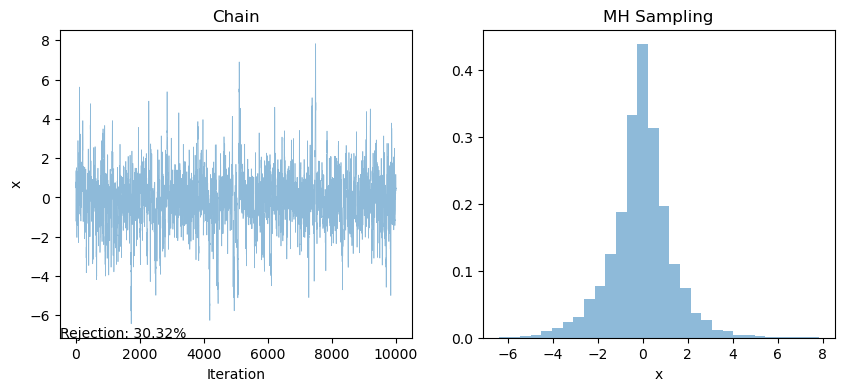

In [83]:
# plot laplace with sigma = 1
x_laplace = mh_generic(
    f=laplace.pdf, burn_in=1e+3, sigma=1
)

plot_sample(x_laplace)

100%|██████████| 10999/10999 [00:04<00:00, 2390.61it/s]


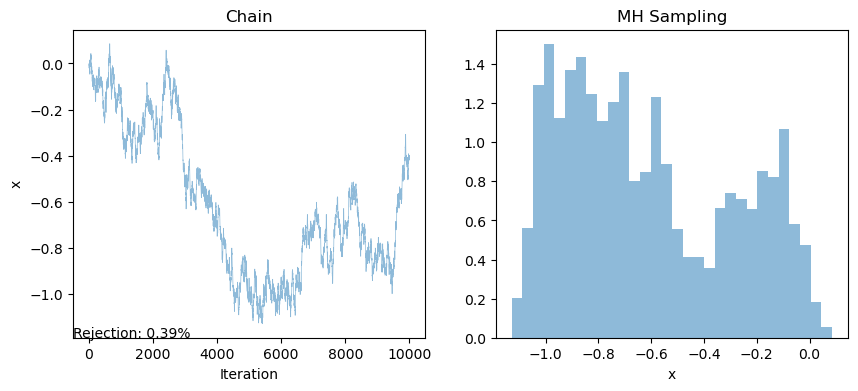

In [84]:
# plot laplace with sigma = 0.01
x_laplace = mh_generic(
    f=laplace.pdf, burn_in=1e+3, sigma=0.01
)

plot_sample(x_laplace)

  0%|          | 0/10999 [00:00<?, ?it/s]/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_14875/2659427215.py:6: RuntimeWarning: invalid value encountered in scalar divide
  (f(y) * norm.pdf(x, loc=y, scale=1)) /
100%|██████████| 10999/10999 [00:04<00:00, 2374.77it/s]


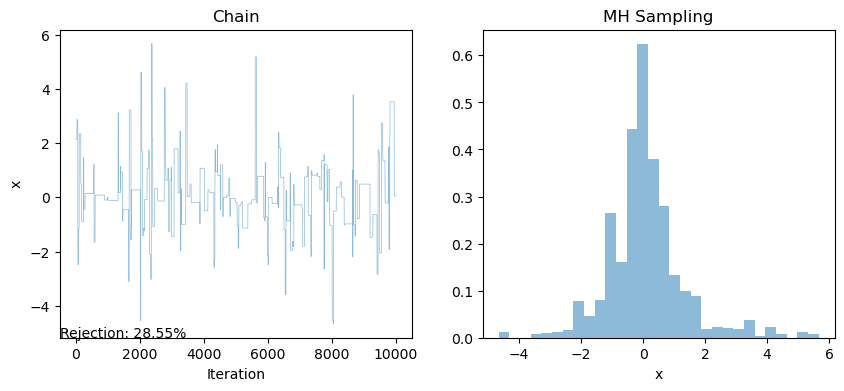

In [85]:
# plot laplace with sigma = 100
x_laplace = mh_generic(
    f=laplace.pdf, burn_in=1e+3, sigma=100
)

plot_sample(x_laplace)

# Problem 8: custom discrete distribution

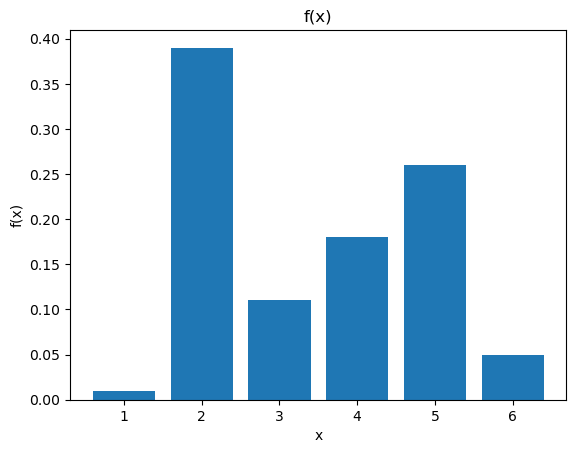

In [111]:
def f4(x):
    return np.select([
        x <= 1,
        x <= 2,
        x <= 3,
        x <= 4,
        x <= 5,
        x <= 6,
    ], [
        0.01, 0.39, 0.11,
        0.18, 0.26, 0.05
    ]).squeeze()
     
# plot f4
x = np.arange(1, 7)
y = f4(x)
fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("f(x)")
plt.show()

In [109]:
def mh_generic_discrete(f, n=10_000, burn_in=1_000, sigma=1, x0=0):
    # mh ratio
    def mh_ratio(x, y):
        alpha_raw = f(y) / f(x)
        return np.minimum(alpha_raw, 1)

    # number of total samples
    n = int(n)
    burn_in = int(burn_in)
    n_samples = int(n + burn_in)

    # step 1: init values
    z = np.empty(shape=n_samples)
    acceptance = np.empty(shape=n_samples-1)
    z[0] = x0

    # step 2: sample
    u = RNG.uniform(size=n_samples-1)
    for i in tqdm(range(1, n_samples)):
        # new proposal
        y = RNG.choice(np.arange(1, 7))  # even dice
        # ratio
        alpha = mh_ratio(z[i-1], y)
        # acceptance
        acceptance[i-1] = np.sign(alpha - u[i-1])
        z[i] = y if acceptance[i-1] >= 0 else z[i-1]

    # step 3: burn-in
    z = z[burn_in:]
    acceptance = acceptance[burn_in:]

    return {
        'sample': z,
        'rejection': np.mean(acceptance < 0)
    }

100%|██████████| 1099/1099 [00:00<00:00, 6909.65it/s]


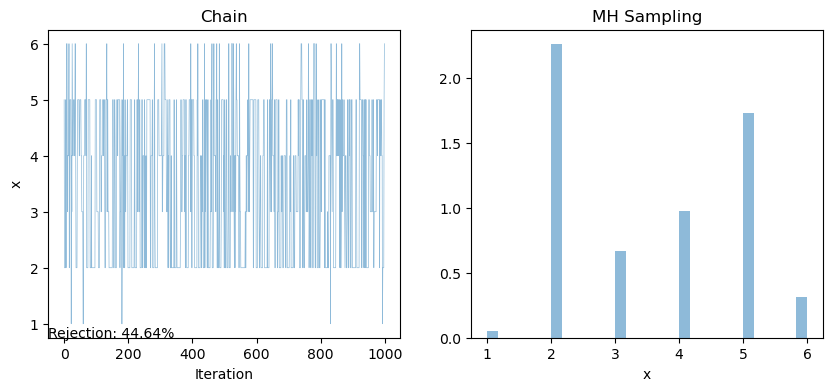

In [112]:
# custom discrete proposal
x_custom_discrete = mh_generic_discrete(
    f=f4, burn_in=1e+2, sigma=100, n=1e+3
)

plot_sample(x_custom_discrete)

In [108]:
np.arange(1, 7)

array([1, 2, 3, 4, 5, 6])